In [1]:
%store -r sheyenne_grasslands_gdf caddo_grasslands_gdf data_dir

In [2]:
# Import necessary packages
import os
import pathlib
from glob import glob

import cartopy.crs as ccrs # CRSs
import pandas as pd # Aggregating and data manipulation
import matplotlib.pyplot as plt # Overlay pandas and xarray plots
import rioxarray as rxr # Work with raster data
import xarray as xr

## Load in climate data

For each grassland: Download one climate variable from the MACAv2 THREDDS data server as raster data.

MACA v2 model: CanESM2
* Climate variable: precipitation
* Emissions scenarios being compared: rcp4.5 and rcp8.5
* Time period: 2076 - 2080
* Monthly predictions

In [3]:
# Make MACA data directory
maca_dir = os.path.join(data_dir, 'maca-dir')
os.makedirs(maca_dir, exist_ok=True)
maca_dir

maca_pattern = os.path.join(maca_dir, '*.nc')
maca_pattern

# Only download once
# if not os.path.exists(maca_path):
#     maca_da = xr.open_dataset(maca_url).squeeze()#.precipitation
#     maca_da.to_netcdf(maca_path)
    # maca_85_ds = xr.open_dataset(maca_url)
    # maca_85_ds.to_netcdf(maca_path)

'C:\\Users\\riede\\earth-analytics\\data\\habitat-suitability\\maca-dir\\*.nc'

In [4]:
# Define function to convert longitude/latitude
def convert_longitude(longitude):
    """Convert longitude range from 0-360 t0 -180-180"""
    return (longitude - 360) if longitude > 180 else longitude

maca_da_list = []
for site_name, site_gdf in {
    'SheyenneGrasslands': sheyenne_grasslands_gdf,
    'CaddoGrasslands': caddo_grasslands_gdf}.items():
    for rcp_value in ['rcp85', 'rcp45']:
        # Define url
        maca_url = (
            'http://thredds.northwestknowledge.net:8080/thredds/dodsC'
            '/MACAV2/CanESM2'
            '/macav2metdata_pr_CanESM2_r1i1p1'
            f'_{rcp_value}'
            '_2076_2080_CONUS'
            '_monthly.nc') 

        # Only download once
        maca_path = os.path.join(maca_dir, f'maca_{site_name}_{rcp_value}_2076_2080_CONUS_monthly.nc')
        print(maca_path)
        if not os.path.exists(maca_path):
             maca_da = xr.open_dataset(maca_url).squeeze().precipitation
             maca_da.to_netcdf(maca_path)

        # Open & Squeeze dataset
        maca_da = xr.open_dataset(maca_path).squeeze().precipitation

        # Define bounds
        bounds_maca = (site_gdf
                        .to_crs(maca_da.rio.crs)
                        .total_bounds)

        # Change maca_ds longitude values to match the grasslands gdfs
        maca_da = maca_da.assign_coords(
            lon=("lon", [convert_longitude(l) for l in maca_da.lon.values]))

        # Set spatial dimensions of maca_da
        maca_da = maca_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

        # Crop maca_da
        maca_da = maca_da.rio.clip_box(*bounds_maca)
        maca_da_list.append(dict(
            site_name=site_name,
            rcp_value=rcp_value,
            da=maca_da))

maca_df = pd.DataFrame(maca_da_list)

# Display maca_df w/o DataArray column
display(maca_df.drop('da', axis='columns'))

# Pull out the data array for the first row
maca_df.da.values[0]

C:\Users\riede\earth-analytics\data\habitat-suitability\maca-dir\maca_SheyenneGrasslands_rcp85_2076_2080_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\habitat-suitability\maca-dir\maca_SheyenneGrasslands_rcp45_2076_2080_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\habitat-suitability\maca-dir\maca_CaddoGrasslands_rcp85_2076_2080_CONUS_monthly.nc
C:\Users\riede\earth-analytics\data\habitat-suitability\maca-dir\maca_CaddoGrasslands_rcp45_2076_2080_CONUS_monthly.nc


,site_name,rcp_value
0,SheyenneGrasslands,rcp85
1,SheyenneGrasslands,rcp45
2,CaddoGrasslands,rcp85
3,CaddoGrasslands,rcp45


<xarray.DataArray 'precipitation' (time: 60, lat: 12, lon: 14)> Size: 40kB
[10080 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 96B 46.1 46.15 46.19 46.23 ... 46.48 46.52 46.56
  * time     (time) object 480B 2076-01-15 00:00:00 ... 2080-12-15 00:00:00
  * lon      (lon) float64 112B -97.48 -97.44 -97.4 ... -97.02 -96.98 -96.94
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

### **Attempting a function to process the climate dataarrays**

In [5]:
def process_maca_da(rcp, df, row):
    """
    Calculate the average annual precipitation.
    -------------------------------------------
    
    This function isolates the DataArray of interest of the MACA DataFrame,
    finds the total precipitation per year of the DataArray,
    and uses the total precipitation per year to calculate the
    average annual precipitation for the time period.
    ------------------------------------------------------------------------
    
    Parameters
    ----------
    rcp : int
        The Representative Concentration Pathway (RCP).
    
    df : DataFrame
        The DataFrame the grassland RCP Precipitation DataArrays are stored in.
    
    row : int
        The row number of the `df`.
    
    Returns
    -------
    grassland_rcp_annual_precip_da : DataArray
        A DataArray of the average annual precipitation.
    """
    # Select the DataArray in a specific row of the `df`
    # for the grassland and `rcp` of interest.
    grassland_rcp_da = df.loc[row, 'da']

    # Calculate the total precipitation
    # for each year of the grassland_rcp_da.
    grassland_rcp_yearly_precip_da = grassland_rcp_da.groupby('time.year').sum()

    # Calculate the average annual precipitation for the time period
    grassland_rcp_annual_precip_da = grassland_rcp_yearly_precip_da.mean(['year'])
    
    return grassland_rcp_annual_precip_da

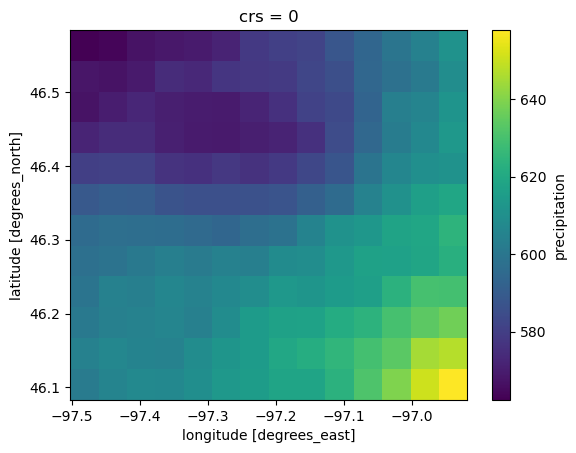

In [6]:
sheyenne_85_annual_precip_da = process_maca_da(85, maca_df, 0)
sheyenne_85_annual_precip_da.plot()

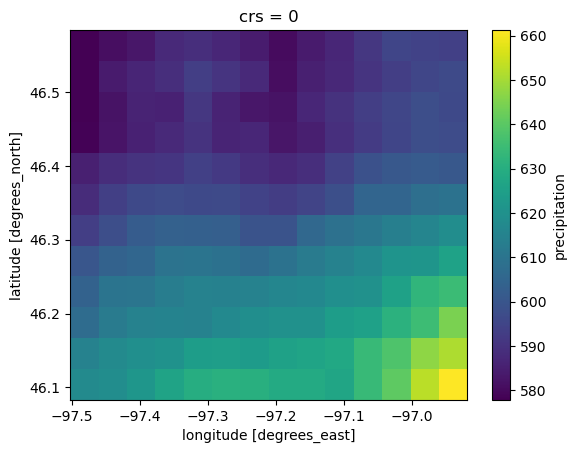

In [7]:
sheyenne_45_annual_precip_da = process_maca_da(45, maca_df, 1)
sheyenne_45_annual_precip_da.plot()

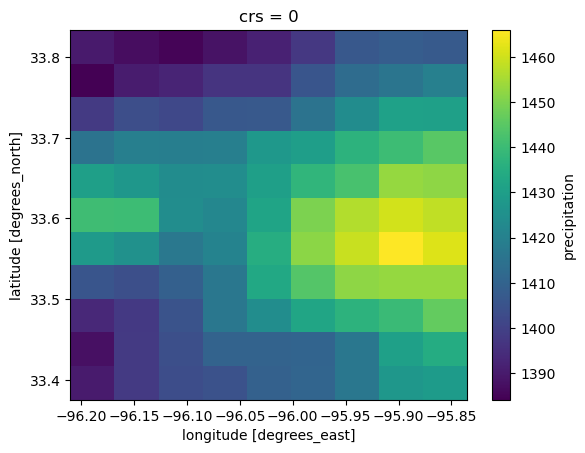

In [8]:
caddo_85_annual_precip_da = process_maca_da(85, maca_df, 2)
caddo_85_annual_precip_da.plot()

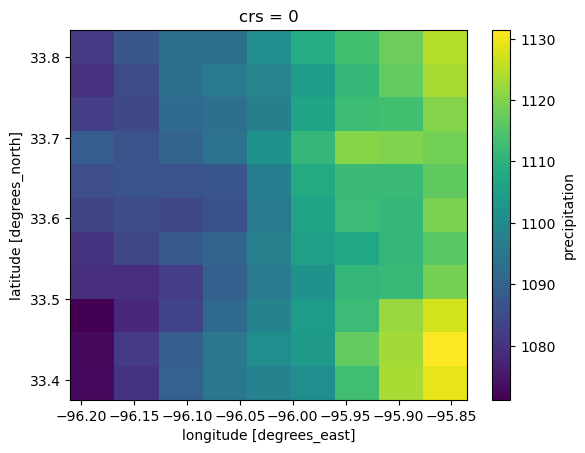

In [9]:
caddo_45_annual_precip_da = process_maca_da(45, maca_df, 3)
caddo_45_annual_precip_da.plot()

In [10]:
%store sheyenne_45_annual_precip_da sheyenne_85_annual_precip_da caddo_45_annual_precip_da caddo_85_annual_precip_da

Stored 'sheyenne_45_annual_precip_da' (DataArray)
Stored 'sheyenne_85_annual_precip_da' (DataArray)
Stored 'caddo_45_annual_precip_da' (DataArray)
Stored 'caddo_85_annual_precip_da' (DataArray)
